In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:

import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
from trainer_test import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train="true", download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train="false", download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = fashion_mnist_classes

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 10

## PLOTTING EMBEDDINGS

In [34]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [16]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 10
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [17]:
batch_images1 = []
batch_images2 = []
for batch_idx, (data, target) in enumerate(siamese_train_loader):
    target = target if len(target) > 0 else None
    if not type(data) in (tuple, list):
        data = (data,)
    batch_images1 = data[0]
    batch_images2 = data[1]
    break


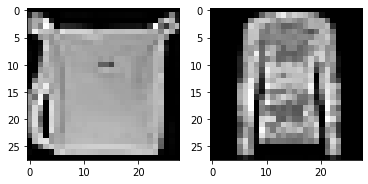

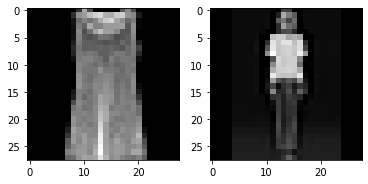

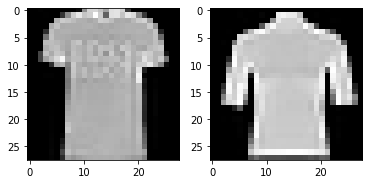

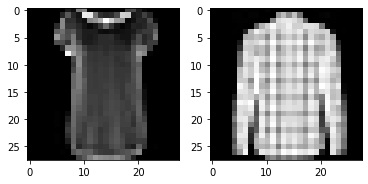

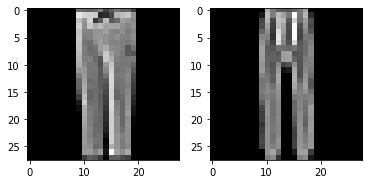

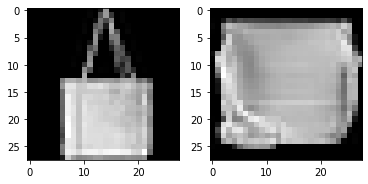

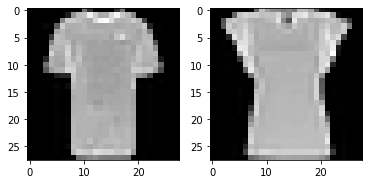

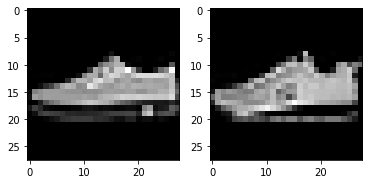

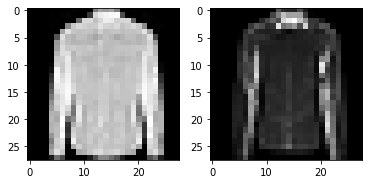

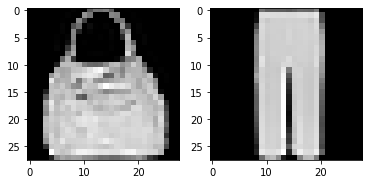

In [18]:
ind = 0
for i in range(len(batch_images1)):
    plt.subplot(121)
    plt.imshow(batch_images1[i].reshape(28,28),cmap="gray")
    plt.subplot(122)
    plt.imshow(batch_images2[i].reshape(28,28),cmap="gray")
    plt.show()


# Training

In [19]:
# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20 # change this to 20
log_interval = 100

In [20]:
epochlosses = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
c:\users\az connects\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, pad

Train: [0/60000 (0%)]	Loss: 0.221573
Train: [12800/60000 (21%)]	Loss: 0.065126
Train: [25600/60000 (43%)]	Loss: 0.048924
Train: [38400/60000 (64%)]	Loss: 0.045264
Train: [51200/60000 (85%)]	Loss: 0.043339
Epoch: 1/20. Train set: Average loss: 0.0499
Epoch: 1/20. Validation set: Average loss: 0.0410
Train: [0/60000 (0%)]	Loss: 0.045321
Train: [12800/60000 (21%)]	Loss: 0.041684
Train: [25600/60000 (43%)]	Loss: 0.040360
Train: [38400/60000 (64%)]	Loss: 0.038191
Train: [51200/60000 (85%)]	Loss: 0.037466
Epoch: 2/20. Train set: Average loss: 0.0390
Epoch: 2/20. Validation set: Average loss: 0.0356
Train: [0/60000 (0%)]	Loss: 0.047407
Train: [12800/60000 (21%)]	Loss: 0.035233
Train: [25600/60000 (43%)]	Loss: 0.032996
Train: [38400/60000 (64%)]	Loss: 0.035400
Train: [51200/60000 (85%)]	Loss: 0.031661
Epoch: 3/20. Train set: Average loss: 0.0334
Epoch: 3/20. Validation set: Average loss: 0.0312
Train: [0/60000 (0%)]	Loss: 0.031149
Train: [12800/60000 (21%)]	Loss: 0.031599
Train: [25600/60000 (

In [21]:
torch.save(model.state_dict(),"siamese_FASHION_MNIST")

In [22]:
model.load_state_dict(torch.load("siamese_FASHION_MNIST"))

<All keys matched successfully>

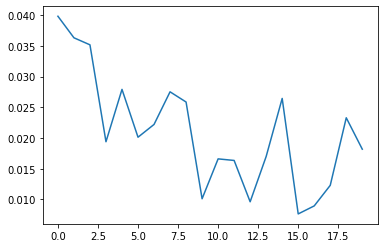

In [23]:
import matplotlib.pyplot as plt 
epochs = []
losses = []
for epoch,loss in epochlosses:
    epochs.append(epoch)
    losses.append(loss[-1])
 plt.plot(epochs,losses)
plt.show()


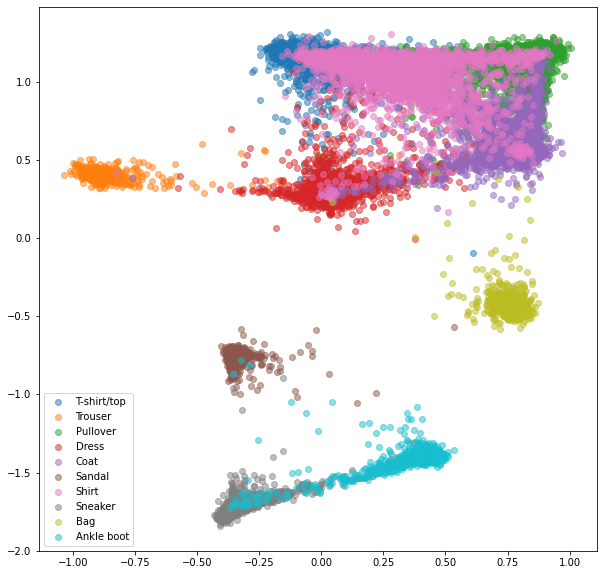

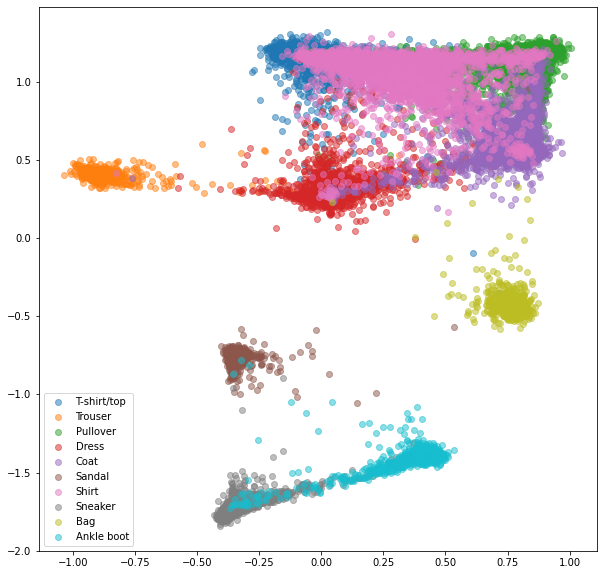

In [37]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Results

In [25]:

with torch.no_grad():
        model.eval()
        difference_coeffs = np.zeros((len(siamese_test_loader.dataset), 2))
        k=0
        for batch_idx, (data, target) in enumerate(siamese_test_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            images0 = data[0]
            images1 = data[1]
            img0embeddings = model.get_embedding(images0).data.cpu().numpy()
            img1embeddings = model.get_embedding(images1).data.cpu().numpy()
            diff = np.array([])

            #for every image set in the batch
            for i in range(len(img0embeddings)):
                dist = np.square(img0embeddings[i][0]-img1embeddings[i][0]) + np.square(img0embeddings[i][1]-img1embeddings[i][1]) 
                dist_tar = np.array([dist,int(target[i])])
                diff = np.append(diff,dist_tar)
            
            diff = np.reshape(diff, (-1, 2))
            difference_coeffs[k:k+len(images0)] = diff
            k += len(images0)
            
            

# Visualize Predictions
Based on our results, we can set a thresold for distance i.e 0.5 for which, 
similar images will have the siamese distance < 0.5 and different ones will give a greater distance

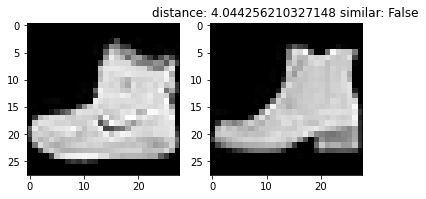

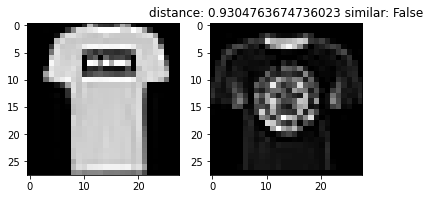

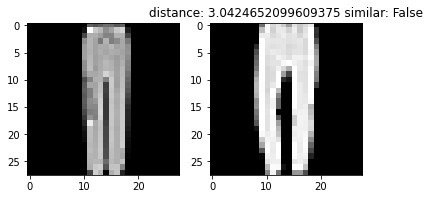

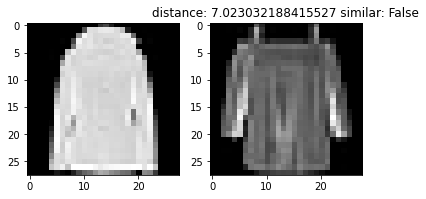

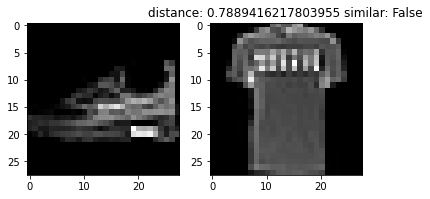

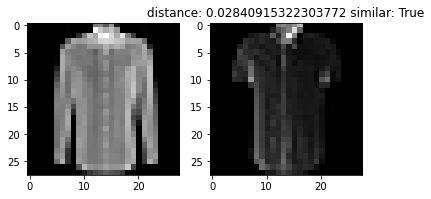

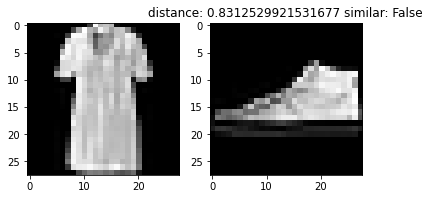

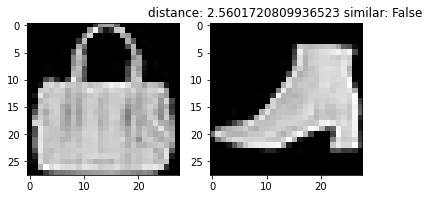

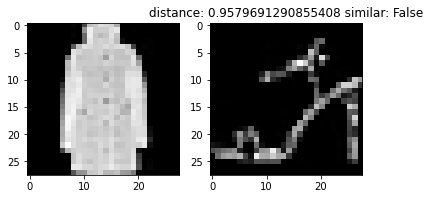

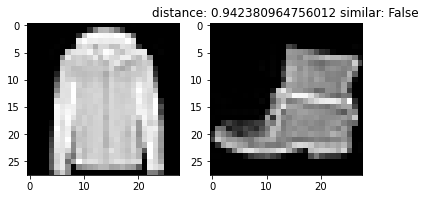

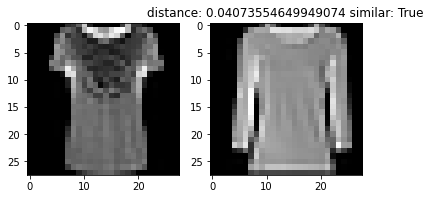

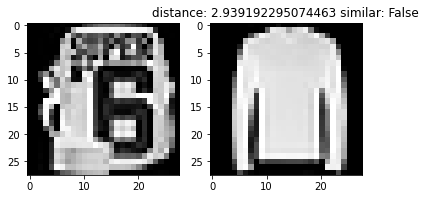

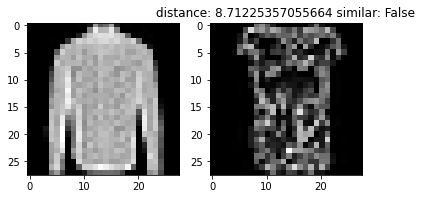

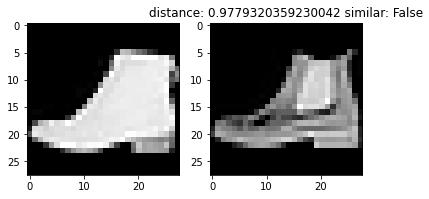

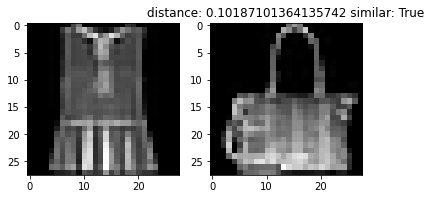

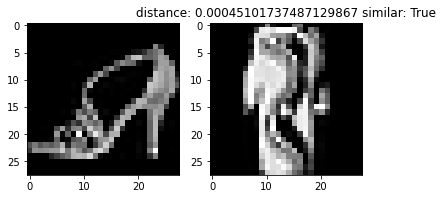

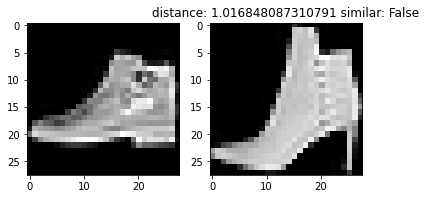

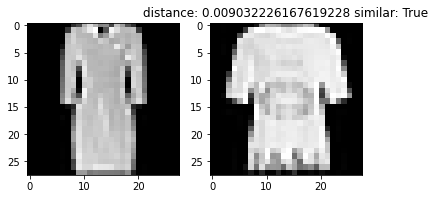

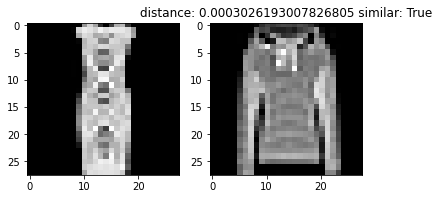

In [39]:
# print(len(difference_coeffs))
for i in range(2):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(1000,1001):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(2000,2002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(3000,3002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(4000,4002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(5000,5002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(6000,6002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(7000,7002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(8000,8002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(9000,9002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")


In [27]:
distances = difference_coeffs[:,0]
targets = difference_coeffs[:,1]
print(distances.shape)
print(targets.shape)

(60000,)
(60000,)


In [28]:
threshold = 0.5

In [29]:
predictions = np.array([])
for x in distances:
    if(x < threshold):
        predictions = np.append(predictions,1.0)
    else:
        predictions = np.append(predictions,0.0)
        
accuracy = len(predictions[predictions == 1])/len(predictions)
print(accuracy*100)

53.388333333333335


In [30]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(targets, predictions)

<AxesSubplot:>

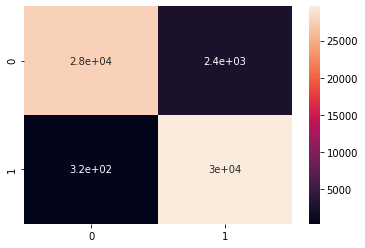

In [31]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [32]:
print(model)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (convnet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
)
